## Analyse du système minimal en 1.5D avec denavit hartenberg, pour valider méthodo.

<div>
<img src="../../SCHEMAS/assembly_diagrams/SchemaModeleJeuxTolerance.png" width="750"/>
</div>

In [1]:
import os
import pickle
import re
import pprint
import numpy as np
import sympy as sp
import scipy
import openturns as ot
import matplotlib.pyplot as plt
import trimesh as tr

from math import pi
from joblib import Parallel, delayed
from importlib import reload
from IPython.display import display, clear_output, HTML, IFrame
from time import time, sleep
from sympy.printing import latex
from trimesh import viewer as trview
from scipy.optimize import OptimizeResult, minimize, Bounds, LinearConstraint

import otaf

I4 = otaf.I4()
J4 = otaf.J4()

#### **Définition des grandeurs nominales de la pièce**

In [2]:
### Different measures of our problem
X1 = 99.8  # Nominal Length of the male piece
X2 = 100.0  # Nominal Length of the female piece
X3 = 10.0  # Nominal width of the pieces
j = X2 - X1  # Nominal play between pieces.
T = 0.2  # Tolerance for X1 and X2. (95% conform)  (= t/2)
t_ = T / 2

#### **Définition du repère global R0 / qui est aussi un repère local de la pièce fixe.**

In [3]:
R0 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x_, y_, z_ = R0[0], R0[1], R0[2]

#### **Définition des coordonnées des points charactéristiques de chaque surface de chaque pièce.**

In [4]:
# Pièce 1 (male)
P1A0, P1A1, P1A2 = (
    np.array((0, X3 / 2, 0.0)),
    np.array((0, X3, 0.0)),
    np.array((0, 0, 0.0)),
)
P1B0, P1B1, P1B2 = (
    np.array((X1, X3 / 2, 0.0)),
    np.array((X1, X3, 0.0)),
    np.array((X1, 0, 0.0)),
)
P1C0, P1C1, P1C2 = (
    np.array((X1 / 2, 0, 0.0)),
    np.array((0, 0, 0.0)),
    np.array((X1, 0, 0.0)),
)

# Pièce 2 (femelle)  # On met les points à hM et pas hF pour qu'ils soient bien opposées! (Besoin??)
P2A0, P2A1, P2A2 = (
    np.array((0, X3 / 2, 0.0)),
    np.array((0, X3, 0.0)),
    np.array((0, 0, 0.0)),
)
P2B0, P2B1, P2B2 = (
    np.array((X2, X3 / 2, 0.0)),
    np.array((X2, X3, 0.0)),
    np.array((X2, 0, 0.0)),
)
P2C0, P2C1, P2C2 = (
    np.array((X2 / 2, 0, 0.0)),
    np.array((0, 0, 0.0)),
    np.array((X2, 0, 0.0)),
)

#### **Définisson les repères locaux de chaque surface substituée.**

In [5]:
# Pièce1
RP1a = np.array([-1 * x_, -1 * y_, z_])
RP1b = R0
RP1c = np.array([-y_, x_, z_])

# Pièce2
RP2a = R0
RP2b = np.array([-1 * x_, -1 * y_, z_])
RP2c = np.array([y_, -1 * x_, z_])

#### **Maintenant construisons les matrices de transformation pour passer du repère global aux repères locaux (et de définition des matrices de déviation et Jeu! )**
- tfrt : transformation from rotation translation

In [6]:
TP1aA0, TP1aA1, TP1aA2 = (
    otaf.geometry.tfrt(RP1a, P1A0),
    otaf.geometry.tfrt(RP1a, P1A1),
    otaf.geometry.tfrt(RP1a, P1A2),
)
TP1bB0, TP1bB1, TP1bB2 = (
    otaf.geometry.tfrt(RP1b, P1B0),
    otaf.geometry.tfrt(RP1b, P1B1),
    otaf.geometry.tfrt(RP1b, P1B2),
)
TP1cC0, TP1cC1, TP1cC2 = (
    otaf.geometry.tfrt(RP1c, P1C0),
    otaf.geometry.tfrt(RP1c, P1C1),
    otaf.geometry.tfrt(RP1c, P1C2),
)

TP2aA0, TP2aA1, TP2aA2 = (
    otaf.geometry.tfrt(RP2a, P2A0),
    otaf.geometry.tfrt(RP2a, P2A1),
    otaf.geometry.tfrt(RP2a, P2A2),
)
TP2bB0, TP2bB1, TP2bB2 = (
    otaf.geometry.tfrt(RP2b, P2B0),
    otaf.geometry.tfrt(RP2b, P2B1),
    otaf.geometry.tfrt(RP2b, P2B2),
)
TP2cC0, TP2cC1, TP2cC2 = (
    otaf.geometry.tfrt(RP2c, P2C0),
    otaf.geometry.tfrt(RP2c, P2C1),
    otaf.geometry.tfrt(RP2c, P2C2),
)

In [7]:
# Transformation matrices dictionary
TMD = {}
TMD["T1c1a"] = otaf.TransformationMatrix(initial=TP1cC0, final=TP1aA0)
TMD["T2a2c"] = otaf.TransformationMatrix(initial=TP2aA0, final=TP2cC0)
TMD["T1c1b"] = otaf.TransformationMatrix(initial=TP1cC0, final=TP1bB0)
TMD["T2b2c"] = otaf.TransformationMatrix(initial=TP2bB0, final=TP2cC0)

TMD["TP1aA1aA0"] = otaf.TransformationMatrix(initial=TP1aA1, final=TP1aA0)
TMD["TP2aA0aA1"] = otaf.TransformationMatrix(initial=TP2aA0, final=TP2aA1)
TMD["TP1aA2aA0"] = otaf.TransformationMatrix(initial=TP1aA2, final=TP1aA0)
TMD["TP2aA0aA2"] = otaf.TransformationMatrix(initial=TP2aA0, final=TP2aA2)

TMD["TP1bB1bB0"] = otaf.TransformationMatrix(initial=TP1bB1, final=TP1bB0)
TMD["TP2bB0bB1"] = otaf.TransformationMatrix(initial=TP2bB0, final=TP2bB1)
TMD["TP1bB2bB0"] = otaf.TransformationMatrix(initial=TP1bB2, final=TP1bB0)
TMD["TP2bB0bB2"] = otaf.TransformationMatrix(initial=TP2bB0, final=TP2bB2)

In [8]:
# Deviation matrix with no defects
DI4 = otaf.DeviationMatrix(index=-1, translations="", rotations="")  # Pas de défauts

### **Construction des boucles pour les équations de compatibilité.** 

Pour ce système simple, seulement deux boucles sont nécessaires.

##### **Boucle de compatibilibté 1 : 2c -> 1c -> 1a -> 2a**

D2c2c -> GP2cC0P1cC0 -> J4 -> D1c1c -> T1c1a -> D1a1a -> GP1aA0P2aA0 -> J4 -> D2a2a -> T2a2c

In [9]:
# Définissons les matrices :
D2c2c = D1c1c = D1a1a = D2a2a = DI4  # Pas de défauts

# GAP 0, contact plan-plan, contact bloqué par minimisation
GP2cC0P1cC0 = otaf.GapMatrix(index=0, translations_blocked="z", rotations_blocked="xy")
# GAP 1, contact plan-plan, tran x et rot z
GP1aA0P2aA0 = otaf.GapMatrix(index=1, translations_blocked="z", rotations_blocked="xy")

expa_1 = otaf.MatrixPolynomeTaylorExpansion(
    [
        D2c2c,
        GP2cC0P1cC0,
        J4,
        D1c1c,
        TMD["T1c1a"],
        D1a1a,
        GP1aA0P2aA0,
        J4,
        D2a2a,
        TMD["T2a2c"],
    ]
).construct_FO_matrix_expansion()
expa_1

Matrix([
[                    1, -gamma_g_0 - gamma_g_1, 0, -gamma_g_0/10 - 50*gamma_g_1 + u_g_0 + v_g_1],
[gamma_g_0 + gamma_g_1,                      1, 0,           5*gamma_g_1 - u_g_1 + v_g_0 + 1/10],
[                    0,                      0, 1,                                            0],
[                    0,                      0, 0,                                            1]])

##### **Boucle  de compatibilibté 2 : 2c -> 1c -> 1b -> 2b**

D2c2c -> GP2cC0P1cC0 -> J4 -> D1c1c -> T1c1b -> D1b1b -> GP1bB0P2bB0 -> J4 -> D2b2b -> T2b2c

In [10]:
# Définissons les matrices :   # D2c2c -> GP2cC0P1cC0 -> D1c1c ->
D1b1b = otaf.DeviationMatrix(index=1, translations="x", rotations="z")  # Défauts plan
GP1bB0P2bB0 = otaf.GapMatrix(
    index=2, translations_blocked="z", rotations_blocked="xy"
)  # GAP 2, jeu plan
D2b2b = otaf.DeviationMatrix(
    index=2, translations="x", rotations="z", inverse=True
)  # Défauts plan #

expa_2 = otaf.MatrixPolynomeTaylorExpansion(
    [
        D2c2c,
        GP2cC0P1cC0,
        J4,
        D1c1c,
        TMD["T1c1b"],
        D1b1b,
        GP1bB0P2bB0,
        J4,
        D2b2b,
        TMD["T2b2c"],
    ]
).construct_FO_matrix_expansion()
expa_2

Matrix([
[                                            1, -gamma_d_1 + gamma_d_2 - gamma_g_0 - gamma_g_2, 0,      50*gamma_d_1 - 50*gamma_d_2 + gamma_g_0/10 + 50*gamma_g_2 + u_g_0 - v_g_2],
[gamma_d_1 - gamma_d_2 + gamma_g_0 + gamma_g_2,                                              1, 0, 5*gamma_d_1 - 5*gamma_d_2 + 5*gamma_g_2 + u_d_1 + u_d_2 + u_g_2 + v_g_0 - 1/10],
[                                            0,                                              0, 1,                                                                              0],
[                                            0,                                              0, 0,                                                                              1]])

In [11]:
    expr_compa_1 = otaf.common.get_relevant_expressions(expa_1)
    expr_compa_2 = otaf.common.get_relevant_expressions(expa_2)

compatibility_expressions = [*expr_compa_1, *expr_compa_2]

### **Définition et expression des contraintes d'interface**

##### **Boucle d'interface 1 côté A :**

In [12]:
# GP1aA1P2aA1 = TP1aA1aA0 GP1aA0P2aA0 J4 TP2aA0aA1 J4
expa_f_1 = otaf.MatrixPolynomeTaylorExpansion(
    [TMD["TP1aA1aA0"], GP1aA0P2aA0, J4, TMD["TP2aA0aA1"], J4]
).construct_FO_matrix_expansion()
expa_f_1

Matrix([
[        1, -gamma_g_1, 0, 5*gamma_g_1 + u_g_1],
[gamma_g_1,          1, 0,               v_g_1],
[        0,          0, 1,                   0],
[        0,          0, 0,                   1]])

In [13]:
# GP1aA2P2aA2 = TP1aA2aA0 GP1aA0P2aA0 J4 TP2aA0aA2 J4
expa_f_2 = otaf.MatrixPolynomeTaylorExpansion(
    [TMD["TP1aA2aA0"], GP1aA0P2aA0, J4, TMD["TP2aA0aA2"], J4]
).construct_FO_matrix_expansion()
expa_f_2

Matrix([
[        1, -gamma_g_1, 0, -5*gamma_g_1 + u_g_1],
[gamma_g_1,          1, 0,                v_g_1],
[        0,          0, 1,                    0],
[        0,          0, 0,                    1]])

##### **Boucle d'interface 2 côté B :**

In [14]:
# GP1bB1P2bB1 = TP1bB1bB0 GP1bB0P2bB0 J4 TP2bB0bB1 J4
expa_f_3 = otaf.MatrixPolynomeTaylorExpansion(
    [TMD["TP1bB1bB0"], GP1bB0P2bB0, J4, TMD["TP2bB0bB1"], J4]
).construct_FO_matrix_expansion()
expa_f_3

Matrix([
[        1, -gamma_g_2, 0, -5*gamma_g_2 + u_g_2],
[gamma_g_2,          1, 0,                v_g_2],
[        0,          0, 1,                    0],
[        0,          0, 0,                    1]])

In [15]:
# GP1bB2P2bB2 = TP1bB2bB0 GP1bB0P2bB0 J4 TP2bB0bB2 J4
expa_f_4 = otaf.MatrixPolynomeTaylorExpansion(
    [TMD["TP1bB2bB0"], GP1bB0P2bB0, J4, TMD["TP2bB0bB2"], J4]
).construct_FO_matrix_expansion()
expa_f_4

Matrix([
[        1, -gamma_g_2, 0, 5*gamma_g_2 + u_g_2],
[gamma_g_2,          1, 0,               v_g_2],
[        0,          0, 1,                   0],
[        0,          0, 0,                   1]])

In [16]:
mask_matrix = sp.Matrix(
    np.array([[0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
)  # Only translation u should be positive
expa_f_1 = expa_f_1.multiply_elementwise(mask_matrix)
expa_f_2 = expa_f_2.multiply_elementwise(mask_matrix)
expa_f_3 = expa_f_3.multiply_elementwise(mask_matrix)
expa_f_4 = expa_f_4.multiply_elementwise(mask_matrix)

In [17]:
expr_fonc_1 = otaf.common.get_relevant_expressions(expa_f_1)
expr_fonc_2 = otaf.common.get_relevant_expressions(expa_f_2)
expr_fonc_3 = otaf.common.get_relevant_expressions(expa_f_3)
expr_fonc_4 = otaf.common.get_relevant_expressions(expa_f_4)

interface_constraints = [*expr_fonc_1, *expr_fonc_2, *expr_fonc_3, *expr_fonc_4]

In [18]:
print("Compatibility equations:")
for i in range(len(compatibility_expressions)):
    display(compatibility_expressions[i])

print("Interface equations:")
for i in range(len(interface_constraints)):
    display(interface_constraints[i])

Compatibility equations:


-gamma_g_0 - gamma_g_1

-gamma_g_0/10 - 50*gamma_g_1 + u_g_0 + v_g_1

5*gamma_g_1 - u_g_1 + v_g_0 + 1/10

-gamma_d_1 + gamma_d_2 - gamma_g_0 - gamma_g_2

50*gamma_d_1 - 50*gamma_d_2 + gamma_g_0/10 + 50*gamma_g_2 + u_g_0 - v_g_2

5*gamma_d_1 - 5*gamma_d_2 + 5*gamma_g_2 + u_d_1 + u_d_2 + u_g_2 + v_g_0 - 1/10

Interface equations:


5*gamma_g_1 + u_g_1

-5*gamma_g_1 + u_g_1

-5*gamma_g_2 + u_g_2

5*gamma_g_2 + u_g_2

In [19]:
TAMP = otaf.ToleranceAnalysisMatrixPreparer(
    compatibility_expressions, interface_constraints, verbose=2
)

TAMP.embedOptimizationVariable()

C_opt = np.array([0, 1, 0, 0, 1, 0, 0, 0, 0])  # None
print(TAMP.deviation_symbols)
print(TAMP.gap_symbols)

[u_d_1, gamma_d_1, u_d_2, gamma_d_2]
[u_g_0, v_g_0, gamma_g_0, u_g_1, v_g_1, gamma_g_1, u_g_2, v_g_2, gamma_g_2, s]


In [20]:
# D'abord les variances des lois si leur influence était unique (et nous a environ 95% de conformité)
T = 0.2  # Tolerance for X1 and X2. (95% conform)  (= t/2)
t_ = T / 2
Cm = 0.3
sigma_e_pos = T / (6 * Cm)

# Le défaut en orientation est piloté par une incertitude sur un angle. On suppose les angles petits << 1 rad
theta_max = T / X3
sigma_e_theta = (2*theta_max) / (6*Cm) 

In [21]:
# Let's make our random vector With openturns
RandDeviationVect = otaf.uncertainty.get_composed_normal_defect_distribution(
    defect_names=TAMP.deviation_symbols,
    sigma_dict = {"alpha":sigma_e_theta, 
                  "beta":sigma_e_theta,
                  "gamma":sigma_e_theta, 
                  "u":sigma_e_pos, 
                  "v":sigma_e_pos, 
                  "w":sigma_e_pos})

RandDeviationVect

Index,Variable,Distribution
0,u_d_1,"Normal(mu = 0, sigma = 0.111111)"
1,gamma_d_1,"Normal(mu = 0, sigma = 0.0222222)"
2,u_d_2,"Normal(mu = 0, sigma = 0.111111)"
3,gamma_d_2,"Normal(mu = 0, sigma = 0.0222222)"


# Calculating probability of failure in the whole imprecise space


### Using the direct optimization model

In [22]:
# Let's first generate a classic LHS design of expezriment of size 16.
D_lambd = len(TAMP.deviation_symbols)
lambda_vect_unconditioned = ot.ComposedDistribution([ot.Uniform(0, 1)] * D_lambd)
lambda_vect_unconditioned.setDescription(list(map(str, TAMP.deviation_symbols)))
N_lambda = 200
lambda_sample_unconditioned = otaf.uncertainty.generateLHSExperiment(lambda_vect_unconditioned ,N_lambda, 999)
#lambda_sample_unconditioned = lambda_sample_unconditioned_generator.generate()
lambda_sample_random = lambda_vect_unconditioned.getSample(N_lambda)
lambda_sample_conditioned = otaf.uncertainty.condition_lambda_sample(lambda_sample_random, squared_sum=True)
print(", ".join(map(str, TAMP.gap_symbols)))
print("\n")
print(", ".join(map(str, TAMP.deviation_symbols)))

u_g_0, v_g_0, gamma_g_0, u_g_1, v_g_1, gamma_g_1, u_g_2, v_g_2, gamma_g_2, s


u_d_1, gamma_d_1, u_d_2, gamma_d_2


#### Calculating over real model

In [23]:
bounds = None
SEED_MC_PF = 6436431
SIZE_MC_PF = int(1e4) #1e4
optimizations_array = np.empty((N_lambda, SIZE_MC_PF), dtype=OptimizeResult)
failure_probabilities, successes, s_values, statuses = [], [], [], []
failed_optimization_points = []

start_time = time()  # Record the start time
for i in range(N_lambda):
    print(f"Doing iteration {i} of {N_lambda}")
    if i>0:
        print(f"Failure probability, Min: {min(failure_probabilities)}, / Max: {max(failure_probabilities)}")
        print(f"Failed {(1-successes).sum()} optimizations on { SIZE_MC_PF}")
        print("s_mean: ", s_values.mean().round(3), "s_min: ", np.nanmin(s_values).round(3), "s_max: ", np.nanmax(s_values).round(3))
        print("Statuses are:", np.unique(statuses))
    ot.RandomGenerator.SetSeed(SEED_MC_PF)
    deviation_samples = np.array(RandDeviationVect.getSample(SIZE_MC_PF)) * np.array(
        lambda_sample_conditioned[i]
    )
    optimizations = otaf.uncertainty.compute_gap_optimizations_on_sample(
            TAMP,
            deviation_samples,
            bounds=bounds,
            n_cpu=-2,
            progress_bar=True,
        )
    successes = np.array([opt.success for opt in optimizations], dtype=bool)
    statuses = np.array([opt.status for opt in optimizations], dtype=int)
    
    if successes.sum() == 0:
        print("All optimizations failed")
        sleep(0.5)

    failed_optimization_points.append(deviation_samples[np.invert(successes), :])
    
    s_values = np.array([opt.fun for opt in optimizations], dtype=float)
    s_values = np.nan_to_num(s_values, nan=np.nanmax(s_values))*-1 # Cause the obj function C is -1*s and failed optimizations count as a negative s
    failure_probabilities.append(np.where(s_values < 0, 1, 0).mean())
    clear_output(wait=True)
print(f"Done {len (lambda_sample_conditioned)} experiments.")
print(f"Elapsed time: {time() - start_time:.3f} seconds.")
failed_optimization_points = np.vstack(failed_optimization_points)

X = otaf.uncertainty.find_best_worst_quantile(np.array(lambda_sample_conditioned), np.array(failure_probabilities), 0.1)
(best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = X

Done 200 experiments.
Elapsed time: 539.993 seconds.


Lower probability of failure: 14.3 %
Upper probability of failure: 20.4 %


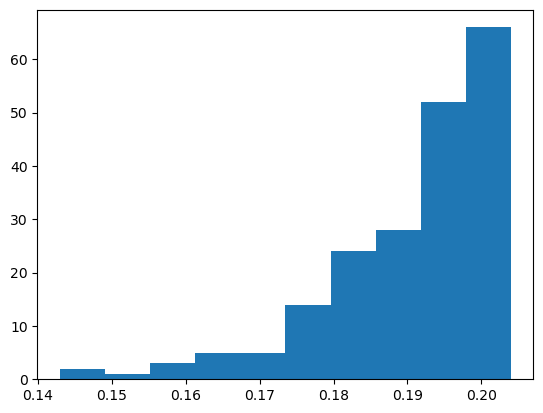

In [24]:
print("Lower probability of failure:", round(min(failure_probabilities) * 100, 4), "%")
print("Upper probability of failure:", round(max(failure_probabilities) * 100, 4), "%")
plt.hist(failure_probabilities)
plt.show()

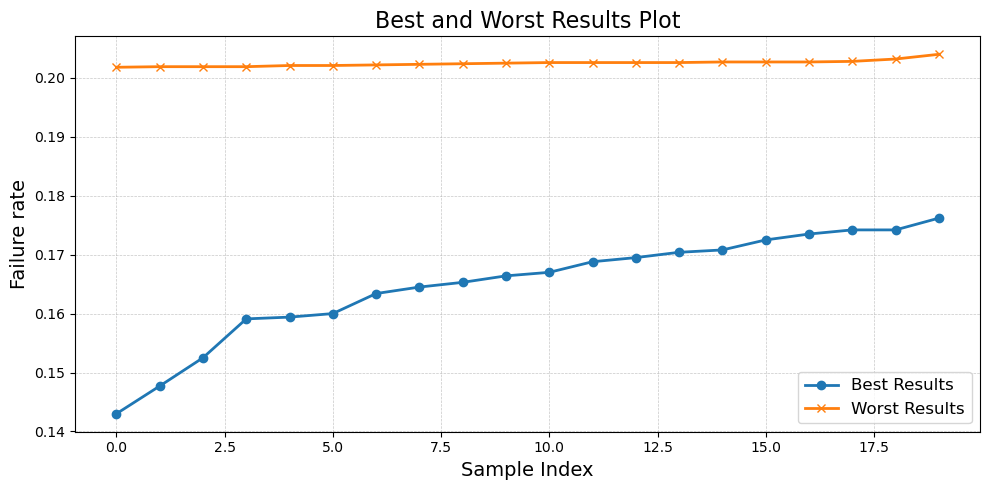

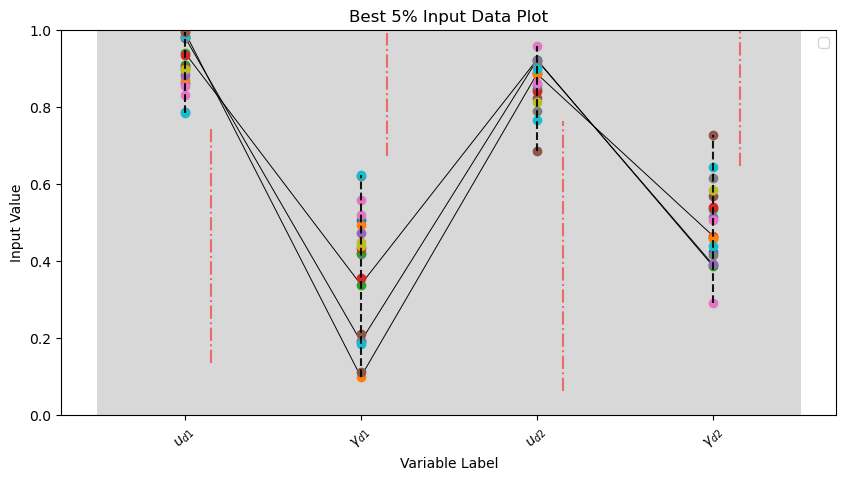

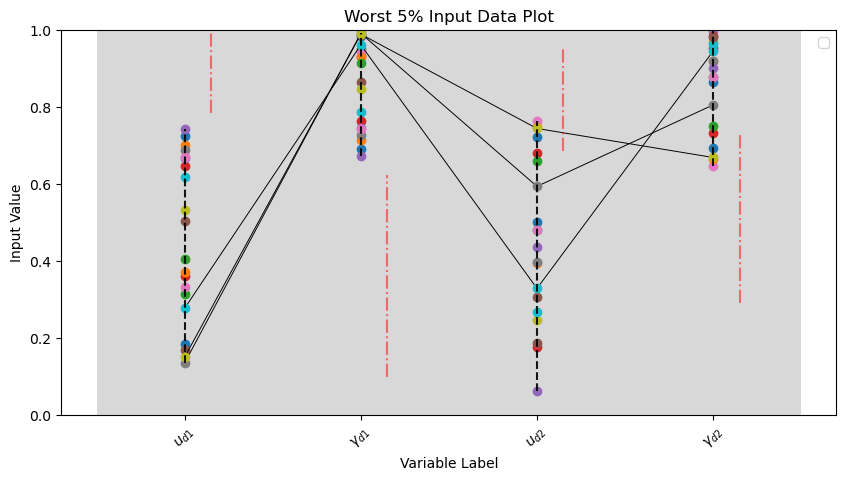

In [25]:
otaf.plotting.plot_best_worst_results(best_5p_res, worst_5p_res, figsize=(10,5))

variable_labels = [var for var in lambda_sample_conditioned.getDescription()]
otaf.plotting.plot_best_worst_input_data(best_5p_lambda, worst_5p_lambda, variable_labels, figsize=(10,5), labels=False)